<span style="color:#478979; font-size:28px; font-weight: bold;">  Price of diamonds prediction and EDA </span> 

<html>
<body>
<div style="color:#478979;
            border-style: solid;
            border-radius: 25px;
            border-color: #478979;
            padding-left: 10px">
       
<span style="color:#478979; font-size:20px; font-weight: bold;">  Brief Description </span><br>
    
The dataset for this project contains attributes and prices of around 54,000 diamonds. <br>
<br>
<span style="font-weight: bold;"> Objectives: </span>
<li>Perform an Explanatory Data Analysis (EDA).
<li>Create a machine learning model to predict the diamond prices. <br>
<br>
<span style="font-weight: bold;"> Regression models used: </span> Linear, Polynomial, Ridge, Lasso, and CatBoost. <br>
<br>


<span style="font-weight: bold;"> The ten features and target are : </span> <br>
<li>Weight: weight of the diamond.<br>
<li>Length (x): length of the diamond.<br>
<li>Width (y): width of the diamond<br>
<li>Depth (z): depth of the diamond.<br>
<li>%Depth: depth percentage. Formula:  z / mean(x, y) = 2 * z / (x + y)<br>
<li>Table: width of top of the diamond relative to the widest point.<br>
<li>Quality: quality of the diamond. Possible values (from best to worst): ideal, premium, very good, good, fair.<br>
<li>Color: color of the diamond. Possible values: from D (best) to J (worst).<br>
<li>Clarity: measurement of how clear the diamond is. Possible values (from best to worst): IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1.<br>
<li>Price (target): price of the diamond in US dollars.<br>

<br>

<span style="font-weight: bold;"> Dataset source: </span> https://www.kaggle.com/datasets/shivam2503/diamonds <br>
</p>
</div>

</body>
</html>

<span style="color:#478979; font-size:28px; font-weight: bold;">  Importing libraries </span> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
import pickle

<span style="color:#478979; font-size:28px; font-weight: bold;">  Loading data and first impressions </span> 

In [2]:
raw_data = pd.read_csv('../input/diamonds/diamonds.csv')
raw_data.drop('Unnamed: 0', axis=1, inplace=True)

#create a copy of the data
df = raw_data.copy()
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Let's change the name and order of the columns for easier readability:

In [3]:
#Changing the column names
col_names = {'carat': 'weight',
             'cut': 'quality',
             'depth': '%depth',
             'x': 'length',
             'y': 'width',
             'z': 'depth'}

df.rename(columns=col_names, inplace=True)

#Changing the order of the columns
df = df[['weight', 'length', 'width', 'depth', '%depth', 'table', 'quality', 'color', 'clarity', 'price']]

df.head()

,weight,length,width,depth,%depth,table,quality,color,clarity,price
0,0.23,3.95,3.98,2.43,61.5,55.0,Ideal,E,SI2,326
1,0.21,3.89,3.84,2.31,59.8,61.0,Premium,E,SI1,326
2,0.23,4.05,4.07,2.31,56.9,65.0,Good,E,VS1,327
3,0.29,4.20,4.23,2.63,62.4,58.0,Premium,I,VS2,334
4,0.31,4.34,4.35,2.75,63.3,58.0,Good,J,SI2,335


Checking the data types:

In [4]:
#Check dtypes
print(df.dtypes)
print('===================')
print(df.dtypes.value_counts())
print('===================')

weight     float64
length     float64
width      float64
depth      float64
%depth     float64
table      float64
quality     object
color       object
clarity     object
price        int64
dtype: object
float64    6
object     3
int64      1
dtype: int64


As expected, 'quality', 'color', and 'clarity' are categorical variables. Let's see their possible values:

In [5]:
print(df['quality'].value_counts(normalize=True))
print('===================')
print(df['color'].value_counts(normalize=True))
print('===================')
print(df['clarity'].value_counts(normalize=True))

Ideal        0.399537
Premium      0.255673
Very Good    0.223990
Good         0.090953
Fair         0.029848
Name: quality, dtype: float64
G    0.209344
E    0.181628
F    0.176900
H    0.153949
D    0.125603
I    0.100519
J    0.052058
Name: color, dtype: float64
SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: clarity, dtype: float64


As expected from the dataset description, the possible values for these features are:
* 'Quality': assumes six possible values.
* 'Color': assumes seven possible values.
* 'Clarity': assumes eight posssible values. 


Now, let's check for missing values across the entire dataset:

In [6]:
# Checking for missing values
df.isna().sum()

weight     0
length     0
width      0
depth      0
%depth     0
table      0
quality    0
color      0
clarity    0
price      0
dtype: int64

Fortunately, there are not missing values.

In [7]:
df.describe()

,weight,length,width,depth,%depth,table,price
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,5.731157,5.734526,3.538734,61.749405,57.457184,3932.799722
std,0.474011,1.121761,1.142135,0.705699,1.432621,2.234491,3989.439738
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000
25%,0.400000,4.710000,4.720000,2.910000,61.000000,56.000000,950.000000
50%,0.700000,5.700000,5.710000,3.530000,61.800000,57.000000,2401.000000
75%,1.040000,6.540000,6.540000,4.040000,62.500000,59.000000,5324.250000
max,5.010000,10.740000,58.900000,31.800000,79.000000,95.000000,18823.000000


**Quick insights:**
* There are 53,940 instances and no missing values.
* The features (quality, color, and clarity) are categorical and need to be enconded.
* Taking a quick look at the table above, we see that some features and the price target might have some outliers. For instance, the mean 'width' is 5.73. However, the maximum value found in the dataset is 58.9. Therefore, we need to check the distribution and possibly some boxplots.


<span style="color:#478979; font-size:28px; font-weight: bold;">  Explanatory Data Analysis (EDA) </span> 

<span style="color:#478979; font-size:22px; font-weight: bold;"> Price wrt numeric features </span>

Let's start off plotting how the price behaves with respect to the numeric features:

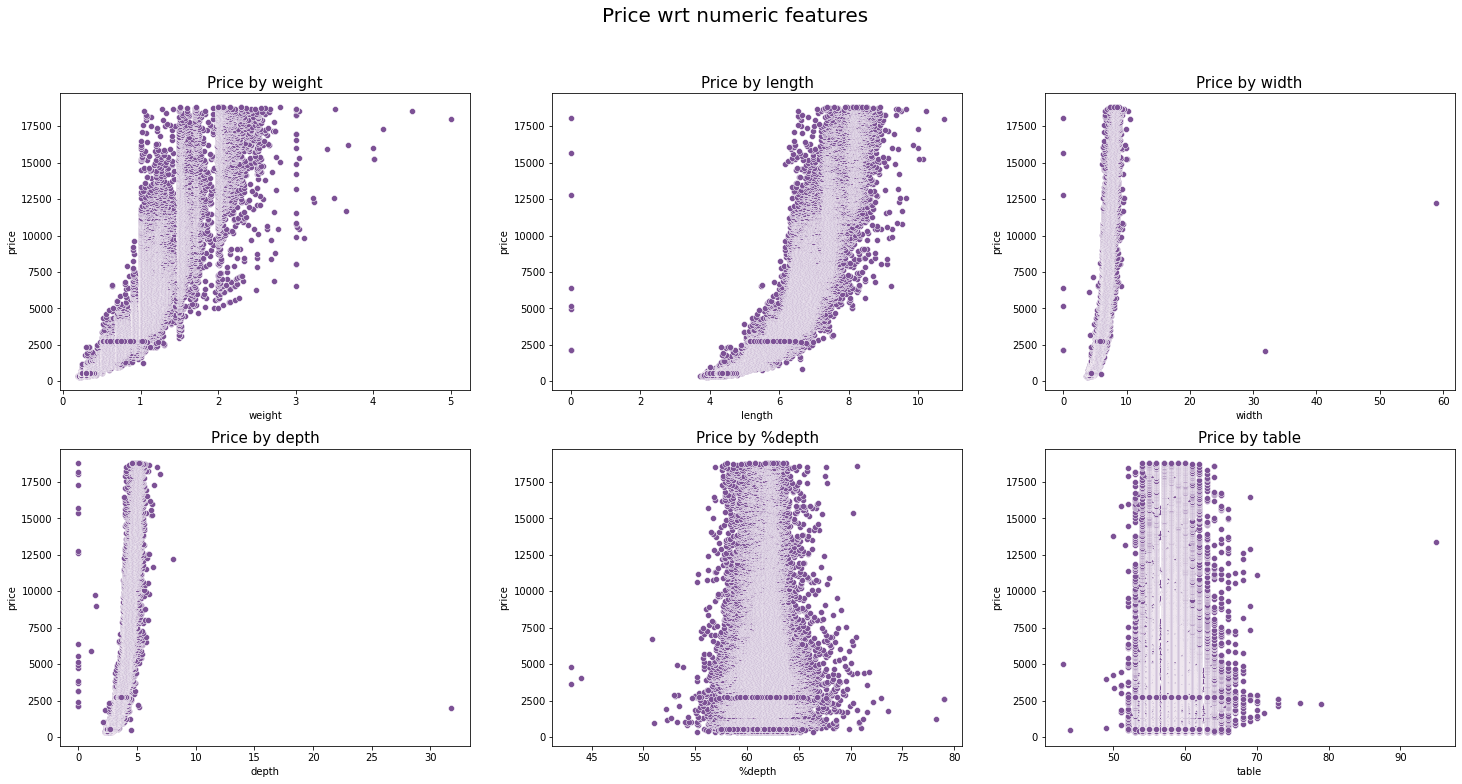

In [8]:
fig, axes = plt.subplots(2, 3, figsize=[25,12])
features = ['weight', 'length', 'width', 'depth', '%depth', 'table']
fig.suptitle('Price wrt numeric features', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

i=0
j=0

for col in features:
    
    sns.scatterplot(data=df, x=col, y='price',  color='#7C5195', ax=axes[i,j])
    axes[i,j].set_title('Price by ' + col)
    j += 1
    if j == 3:
        j = 0
        i = 1

**Insights:**
* Weight, length, width, and depth seem to have a higher correlation with price.
* There is no evident correlation between price and both %depth and table. 
* There seem to be some outliers, especially in width and depth, as well as %depth and price.

Let's plot a correlation heatmap to dig in a bit deeper:

<span style="color:#478979; font-size:22px; font-weight: bold;"> Correllation Heatmap </span>

In [9]:
fig = px.imshow(round(df.corr(), 2), text_auto=True,
                width=800, height=600,
                labels={'color':'Correlation'},
                title='Correlation Heatmap')
fig.show()

**Insight:**
* As expected, high correlation between the sizes of the diamonds and their price.
* Lower correlation between table and price.
* Almost no correlation between %depth and price. We might want to remove this feature to build the ML models.
* Correllation between numeric features and price are positve. Meaning that the higher the size of the diamond, the more costly it is, which actually makes sense.

<span style="color:#478979; font-size:22px; font-weight: bold;"> Dealing with outliers </span>

Now, coming back to the outliers, let's plot some boxplots:

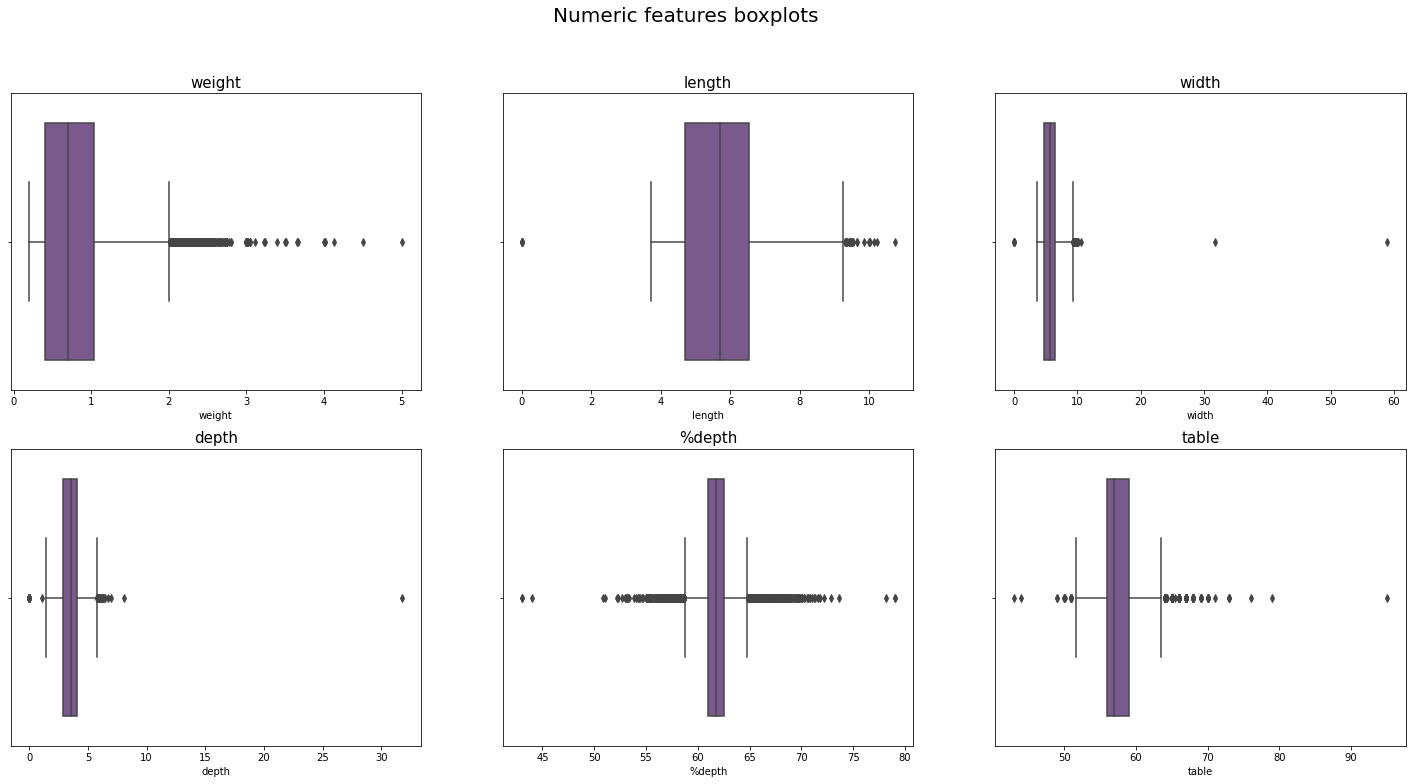

In [10]:
fig, axes = plt.subplots(2, 3, figsize=[25,12])
features = ['weight', 'length', 'width', 'depth', '%depth', 'table']
fig.suptitle('Numeric features boxplots', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

i=0
j=0

for col in features:
    
    sns.boxplot(data=df, x=col,  color='#7C5195', ax=axes[i,j])
    axes[i,j].set_title(col)
    j += 1
    if j == 3:
        j = 0
        i = 1

**Insight:**
I would say that we are definitely in presence of outliers. Since the dataset is large enough (53,000 instances), I decided to remove some of these values so that the ML models generalize better.

To handle these outliers, I set mininium and maximum values for each feature looking at the scatter plots shown above. 
* Length: remove values below 2.
* Width: remove values above 20.
* Depth: remove values equal to zero, and values over 15.
* Table: remove values over 90.

In [11]:
# DROP OUTLIERS
outliers = []
# Outliers in length
entries = df[df['length']<2].index # There are 8 entries with lenth zero, we are going to delete those observations.
outliers.extend(entries)

# Outliers in width
entries = df[df['width']>20].index
outliers.extend(entries)

# Outliers in depth
entries = df[(df['depth'] == 0) | (df['depth']>15)].index
outliers.extend(entries)

# Outliers in table
entries = df[df['table'] > 90].index
outliers.extend(entries)

# Drop ouliers altogether
df.drop(outliers, axis=0, inplace=True)

# Check how many outliers were removed
print(f'Outliers removed: {len(outliers)}')

Outliers removed: 32


Let's replot the price with respect to the numeric features and see the difference:

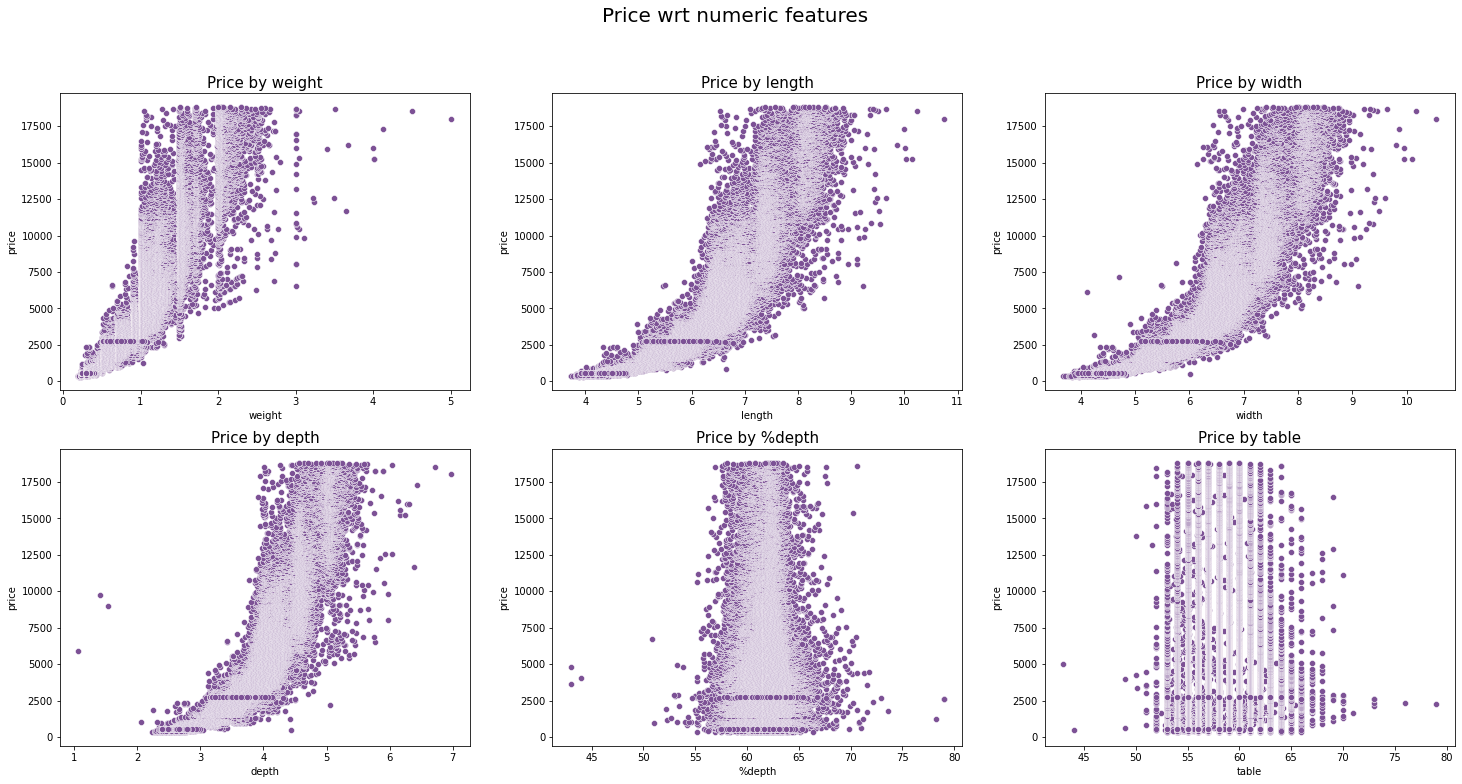

In [12]:
fig, axes = plt.subplots(2, 3, figsize=[25,12])
features = ['weight', 'length', 'width', 'depth', '%depth', 'table']
fig.suptitle('Price wrt numeric features', fontsize=20)
plt.rcParams['axes.titlesize'] = 15

i=0
j=0

for col in features:
    
    sns.scatterplot(data=df, x=col, y='price',  color='#7C5195', ax=axes[i,j])
    axes[i,j].set_title('Price by ' + col)
    j += 1
    if j == 3:
        j = 0
        i = 1

**Insight:**
* The plots look much better. The model will definitely generalize better. 
* Important: only 32 instances were removed, which accounts for only **0.059%** of the data. 

<span style="color:#478979; font-size:22px; font-weight: bold;"> Prices by weight and different qualities </span>

Weight is the most correlated feature to price. Then, let's check how price behaves with respect to weight with different diamond qualities:

In [13]:
colors = ['#4F3EBC', '#CA4CB7', '#2B8639', '#A0C173', '#DA933F']
fig = px.scatter(df, x='weight', y='price', color='quality', width=1000, height=500, 
                 color_discrete_sequence=colors,
                 category_orders={'quality':['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']})
fig.update_layout(
    title="Price by weight and quality",
    xaxis_title="Weight",
    yaxis_title="Price")
fig.show()

**Insight:**
* The graphic is interactive, feel free to play around with it.
* Overall, we can see that for the same value of weight, the price of the diamonds are higher for better qualities.
* Such insight makes sense since between two diamons of the same weight, the one with better quality should be more expensive.
* However, it is not that straightforward as other variables such 'color', 'clarity' and even the 'sizes' are also taken into account on the diamond's price.

<span style="color:#478979; font-size:22px; font-weight: bold;"> Prices by weight and different clarities </span>

In [14]:
colors = ['#4F3EBC', '#CA4CB7', '#2B8639', '#A0C173', '#DA933F', '#D7E33E', '#D13F33', '#51524B']
fig = px.scatter(df, x='weight', y='price', color='clarity', width=1000, height=500, 
                 color_discrete_sequence=colors,
                 category_orders={'clarity':['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'][-1:]},
                 title="Price by weight and clarity")
fig.update_layout(
    xaxis_title="Weight",
    yaxis_title="Price")
fig.show()

**Insight:**
* The better clarity (being IF the best), the more expensive the diamond is.

<span style="color:#478979; font-size:22px; font-weight: bold;"> Prices by weight and different colors </span>

In [15]:
colors = ['#4F3EBC', '#CA4CB7', '#2B8639', '#A0C173', '#DA933F', '#D7E33E', '#D13F33']
fig = px.scatter(df, x='weight', y='price', color='color', width=1000, height=500, 
                 color_discrete_sequence=colors,
                 category_orders={'clarity':['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'][-1:]},
                 title="Price by weight and color")
fig.update_layout(
    xaxis_title="Weight",
    yaxis_title="Price")
fig.show()

**Insight:**
* The better color (being E the best), the more costly the diamond is.

<span style="color:#478979; font-size:22px; font-weight: bold;"> Distribution </span>

Let's check the distribution and skewness of the target and features:

----- SKEWNESS ------------
price skewness = 1.62
weight skewness = 1.12
length skewness = 0.4
width skewness = 0.39
depth skewness = 0.39
---------------------------


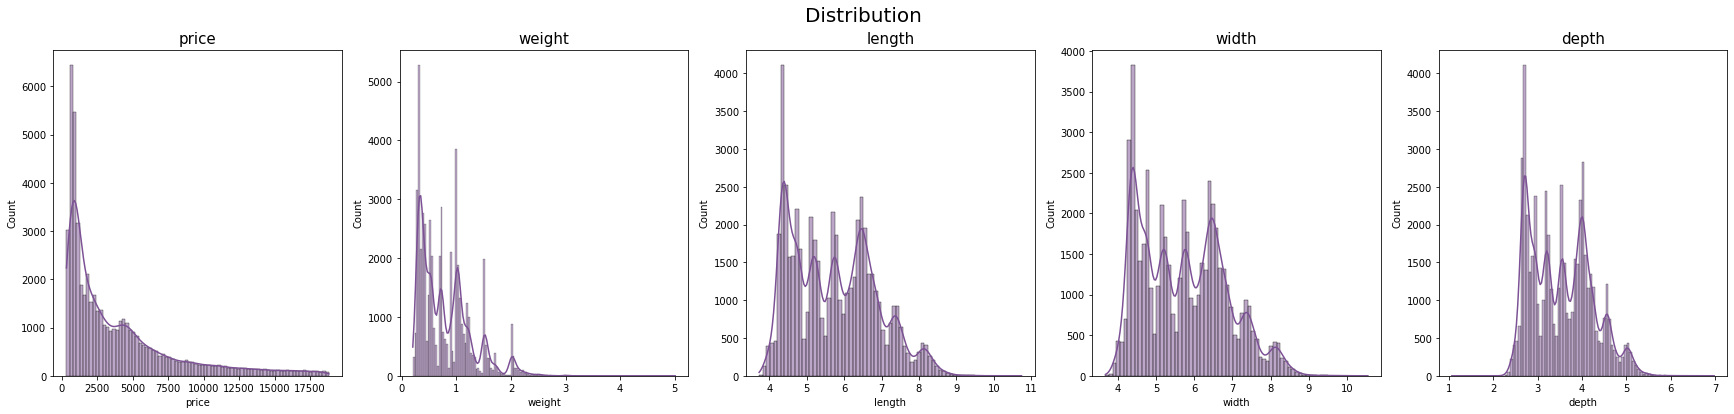

In [16]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(1, 5, figsize=[30,6])
axes.flatten()
fig.suptitle('Distribution', fontsize=20)
plt.rcParams['axes.titlesize'] = 15
j = 0
variables = ['price', 'weight', 'length', 'width', 'depth']


for col in variables:
    sns.histplot(data=df, x=col, kde=True, ax=axes[j], color='#7C5195')
    axes[j].set_title(col)

    j+=1
    print('{} skewness = {}'.format(col, round(df[col].skew(), 2)))
print('---------------------------')

**Insights:**
* All varaibles are positive skewed. If possible, we need to get those values closer to zero.

<span style="color:#478979; font-size:18px; font-weight: bold;"> Applying log and boxcox transformations </span>

Different types of transformations were applied to each variable. The best performers were boxcox for price and weight, and logarithmic transformation for the rest.

----- SKEWNESS WITH TRANSFORMATIONS ---------
Price skewness box cox transformation: 0.02
Weight skewness box cox transformation: 0.03
length skewness log transformation: 0.15
width skewness log transformation: 0.14
depth skewness log transformation: 0.16
---------------------------------------------


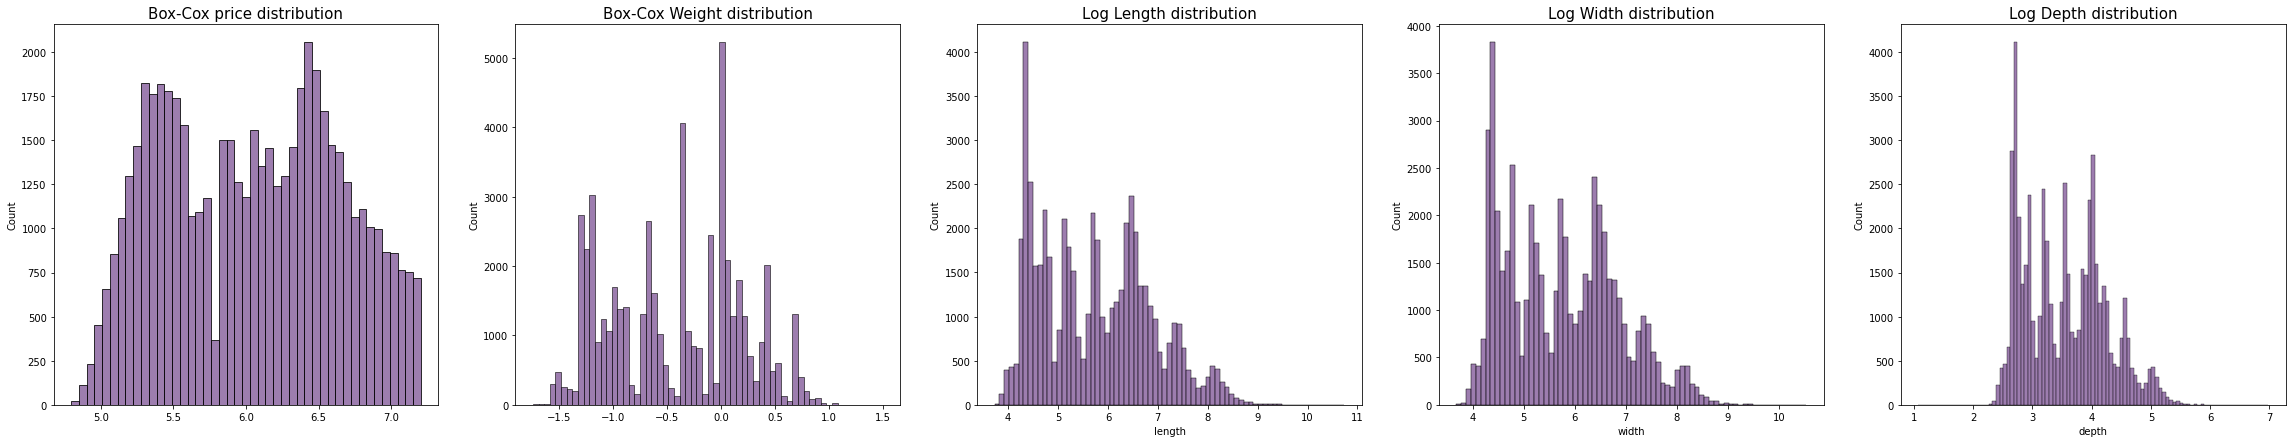

In [17]:
print('----- SKEWNESS WITH TRANSFORMATIONS ---------')

weigth_boxcox = stats.boxcox(df['weight'])[0]
skew_weight_boxcox = pd.Series(weigth_boxcox).skew()
price_boxcox = stats.boxcox(df['price'])[0]
skew_price_boxcox = pd.Series(price_boxcox).skew()

fig, axes = plt.subplots(1, 5, figsize=[40,7])
axes.flatten()

sns.histplot(data=pd.Series(price_boxcox), color='#7C5195', ax=axes[0])
sns.histplot(data=pd.Series(weigth_boxcox), color='#7C5195', ax=axes[1])

j = 2
for feature in df.columns[1:4]:
    sns.histplot(data=df[feature], color='#7C5195', ax=axes[j])
    j += 1
    
axes[0].set_title('Box-Cox price distribution', size=15)
axes[1].set_title('Box-Cox Weight distribution', size=15)
axes[2].set_title('Log Length distribution', size=15)
axes[3].set_title('Log Width distribution', size=15)
axes[4].set_title('Log Depth distribution', size=15)


print('Price skewness box cox transformation: {}'.format(round(skew_weight_boxcox,2)))
print('Weight skewness box cox transformation: {}'.format(round(skew_price_boxcox,2)))

for feature in df.columns[1:4]:
    print('{} skewness log transformation: {}'.format(feature, round(np.log1p(df[feature]).skew(),2)))

print('-'*45)
plt.show()

**Insight:**
* Now, the skweness is much lower for all varialbes. Price and weight are really close to zero. 

<span style="color:#1D6035; font-size:28px; font-weight: bold;">  Data Preprocessing </span> 

<span style="color:#478979; font-size:18px; font-weight: bold;"> Reset the index </span>

In [18]:
# We can reset the index because we drop some values, so that we avoid having possible issues later on
df.reset_index(drop=True, inplace=True)

<span style="color:#478979; font-size:22px; font-weight: bold;">  Let's apply log and boxcox transformation to the data </span>

In [19]:
df_t = df.copy()

# Let's apply box-cox transformation to target 'price' and feature 'weight'
for col in ['price', 'weight']:
    new_col = col + '_boxcox'
    var_boxcox = stats.boxcox(df_t[col])[0]
    boxcox = pd.DataFrame(pd.Series(var_boxcox),
                          index=df_t.index,
                          columns=[new_col])

    df_t = pd.concat([df_t, boxcox], axis=1)
    df_t.drop(col, axis=1, inplace=True)

# Let's apply log to 'length', 'width', and 'depth'
for col in ['length', 'width', 'depth']:
    df_t[col] = df_t[col].apply(np.log1p)

df_t.head()

,length,width,depth,%depth,table,quality,color,clarity,price_boxcox,weight_boxcox
0,1.599388,1.605430,1.232560,61.5,55.0,Ideal,E,SI2,4.795538,-1.577269
1,1.587192,1.576915,1.196948,59.8,61.0,Premium,E,SI1,4.795538,-1.682331
2,1.619388,1.623341,1.196948,56.9,65.0,Good,E,VS1,4.797615,-1.577269
3,1.648659,1.654411,1.289233,62.4,58.0,Premium,I,VS2,4.811966,-1.313634
4,1.675226,1.677097,1.321756,63.3,58.0,Good,J,SI2,4.813990,-1.238853


<span style="color:#478979; font-size:18px; font-weight: bold;"> Removing 'table' and '%depth' from the data </span>

Let's remove features 'table' and '%depth' as they have a very low correlation with the target 'price':

In [20]:
# Dropping 'table and '%depth' variables
df_t.drop(['table', '%depth'], axis=1, inplace=True)

<span style="color:#478979; font-size:18px; font-weight: bold;"> Changing name and order of columns </span>

In [21]:
#Changing the column names
col_names = {'price_boxcox': 'price',
             'weight_boxcox': 'weight'}

df_t.rename(columns=col_names, inplace=True)

#Changing the order of the columns
df_t = df_t[['weight', 'length', 'width', 'depth', 'quality', 'color', 'clarity', 'price']]
df_t.head()

,weight,length,width,depth,quality,color,clarity,price
0,-1.577269,1.599388,1.605430,1.232560,Ideal,E,SI2,4.795538
1,-1.682331,1.587192,1.576915,1.196948,Premium,E,SI1,4.795538
2,-1.577269,1.619388,1.623341,1.196948,Good,E,VS1,4.797615
3,-1.313634,1.648659,1.654411,1.289233,Premium,I,VS2,4.811966
4,-1.238853,1.675226,1.677097,1.321756,Good,J,SI2,4.813990


<span style="color:#478979; font-size:22px; font-weight: bold;">  Encoding </span>

The categorical features need to encoded. I am going to try Ordinal Encoding and One-Hot Encoding and see which one performs better in a simple linear regression model. 

<span style="color:#478979; font-size:18px; font-weight: bold;">  Ordinal Encoding </span>

In [22]:
# Lets create a df with ordinal encoding and then another one with OneHotEncoder
df_ord_enc = df_t.copy() 

a = df[['quality', 'color', 'clarity']]

enc = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ['J', 'I', 'H', 'G', 'F', 'E', 'D'], ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
new_dat = enc.fit_transform(a)

new_df = pd.DataFrame(new_dat, 
                      index=df_ord_enc.index, 
                      columns=['quality_enc', 'color_enc', 'clarity_enc'])

df_ord_enc = pd.concat([df_ord_enc, new_df], axis=1) 

df_ord_enc.drop(['quality', 'color', 'clarity'], axis=1, inplace=True)

<span style="color:#478979; font-size:18px; font-weight: bold;">  One-Hot Encoding </span>

In [23]:
# Now, let's do OneHotEncoder
df_oh_enc = df_t.copy()
enc = OneHotEncoder(drop='first')

for col in df.select_dtypes('object').columns.tolist():
    new_dat = enc.fit_transform(df_oh_enc[[col]])
    column = df_oh_enc[col].unique().tolist()
    new_df = pd.DataFrame(new_dat.toarray(),
                          index=df_oh_enc.index,
                          columns=column[1:])
    
    df_onehot_enc = pd.concat([df_oh_enc, new_df], axis=1)

df_onehot_enc.drop(df_oh_enc.select_dtypes('object').columns.tolist(), axis=1, inplace=True)

<span style="color:#1D6035; font-size:28px; font-weight: bold;">  Modeling </span> 

**Important:** I am using cross validation to test the performance of all models. I will select the model with the highest **r2 score with cross validation (5-fold).**

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  1. Linear Regression </span> 

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Linear regression (One Hot Encoder) </span>

In [24]:
# Splitting the dataset with one-hot encoding
X = df_onehot_enc.drop('price', axis=1)
y = df_onehot_enc['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=420)


# Creating the pipeline
s = StandardScaler()
lr = LinearRegression()

estimator = Pipeline([("scaler", s),
                      ("linear_regression", lr)])

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
linear_reg_r2_score = cross_val_score(estimator, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', linear_reg_r2_score)

Cross validation R2 score: 0.9656


**Cross validation R2 score**: 0.9656

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Linear regression (Ordinal Encoder) </span> 

In [25]:
# Splitting the dataset wih ordinal encoding
X = df_ord_enc.drop('price', axis=1)
y = df_ord_enc['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=420)


# Creating the pipeline
s = StandardScaler()
lr = LinearRegression()

estimator = Pipeline([("scaler", s),
                      ("linear_regression", lr)])

estimator.fit(X_train, y_train)

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
linear_reg_r2_score = cross_val_score(estimator, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', linear_reg_r2_score)

Cross validation R2 score: 0.9796


**Cross validation R2 score**: 0.9796

**Insights:**
* Ordinal encoding shows better results than One-Hot encoding, with a cross validation R2 score of **0.9796** and **0.9656**, respectively.
* Therefore, from now we are going to use only Ordinal Encoder for the rest of the models.


So, let's split the data once again:

In [26]:
X = df_ord_enc.drop('price', axis=1)
y = df_ord_enc['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=420)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37741, 7), (16175, 7), (37741,), (16175,))

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  2. Polynomial Regression </span> 

Let's do a grid search to find the best performing degree:

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Grid Search </span> 

In [27]:
PolyF = PolynomialFeatures(include_bias=False)
s = StandardScaler()
lr = LinearRegression()

# Creating pipeline
pipeline = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('LinearRegression', lr)]
)

param_grid = {'PolyFeatures__degree': np.arange(2,4)}

poly_reg = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
poly_reg.fit(X_train, y_train)

print('The best performing degree is:', poly_reg.best_params_)

The best performing degree is: {'PolyFeatures__degree': 2}


**Insight:**
* The best degree to use is 2.


<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Score </span> 

In [28]:
# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
poly_reg_r2_score = cross_val_score(poly_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', poly_reg_r2_score)

Cross validation R2 score: 0.9829


**Cross validation R2 score:** 0.9829

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Train final Polynomial Regression model (degree=2) </span>

Let's train the model and check the coefficients for each feature in the polynomial regression:

In [29]:
# Creating pipeline
PolyF = PolynomialFeatures(degree=2, include_bias=False)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('LinearRegression', lr)]
)

poly_reg = estimator.fit(X_train, y_train)

# Finding the coefficients
features = poly_reg.named_steps['PolyFeatures'].get_feature_names_out()
features_df = pd.DataFrame()
features_df['Features'] = features
coef = poly_reg.named_steps['LinearRegression'].coef_.ravel()
features_df['Coefficients'] = coef.round(2)

print(features_df.sort_values(by='Coefficients', ascending=False).head(5))
print()
print(features_df.sort_values(by='Coefficients', ascending=False).tail(5))

        Features  Coefficients
9   weight width         14.96
14      length^2         12.01
2          width          9.41
16  length depth          7.00
20       width^2          4.06

         Features  Coefficients
3           depth         -2.72
10   weight depth         -3.52
1          length         -3.91
8   weight length        -12.44
15   length width        -23.75


**Insight:**
* From the table above we can check the most important features for the Polynomal Regression model.
* weight*width feature has the highest positive coefficient.
* length*width feature has the highest negative coefficient.

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  REGULARIZATION </span> 

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  3. Ridge Regression </span> 

Let's regularize the see if we can generalize it better. First, I am using Ridge regularization with Randomized Search:

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Randomized Search </span> 

In [30]:
# Creating pipeline
PolyF = PolynomialFeatures(include_bias=False)
s = StandardScaler()
ridge = Ridge(random_state=42)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('Ridge', ridge)]
)

alpha = [0.001, 0.1, 1]
degrees = [2, 3, 4]
param_grid = [{'Ridge__alpha': alpha,
              'PolyFeatures__degree': degrees}]

random_search = RandomizedSearchCV(estimator, param_grid, scoring='r2', cv=3,
                                   n_iter=5, random_state=42, n_jobs=-1)

ridge_reg = random_search.fit(X_train, y_train)

# Best hyperparameters
print('The best hyperparameters are:', ridge_reg.best_params_)

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
ridge_reg_r2_score = cross_val_score(ridge_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', ridge_reg_r2_score)

The best hyperparameters are: {'Ridge__alpha': 0.1, 'PolyFeatures__degree': 4}
Cross validation R2 score: 0.9888


**Cross validation R2 score:** 0.9888

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Grid Search </span> 

In [31]:
PolyF = PolynomialFeatures(degree=4, include_bias=False)
s = StandardScaler()
ridge = Ridge(random_state=42)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('Ridge', ridge)]
)

alpha = [0.05, 0.15, 0.2]

param_grid = {'Ridge__alpha': alpha}

ridge_reg = GridSearchCV(estimator, param_grid, cv=3, n_jobs=-1, scoring='r2')
ridge_reg = ridge_reg.fit(X_train, y_train)

# Best hyperparameters
print('The best hyperparameters are:', ridge_reg.best_params_)

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
ridge_reg_r2_score = cross_val_score(ridge_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', ridge_reg_r2_score)

The best hyperparameters are: {'Ridge__alpha': 0.05}
Cross validation R2 score: 0.9889


**Cross validation R2 score:** 0.9889

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Train final Ridge Regression model (degree=4, alpha=0.05) </span>

In [32]:
# Creating pipeline
PolyF = PolynomialFeatures(degree=4, include_bias=False)
ridge = Ridge(alpha=0.05, random_state=42)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('Ridge', ridge)]
)

rige_reg = estimator.fit(X_train, y_train)

# Finding the coefficients
coef_df = pd.DataFrame()
coef_df['Feature'] = rige_reg.named_steps['PolyFeatures'].get_feature_names_out()
coef_df['Coef'] = rige_reg.named_steps['Ridge'].coef_

print(coef_df.sort_values(by='Coef', ascending=False).head(5))
print()
print(coef_df.sort_values(by='Coef', ascending=False).tail(5))

                                 Feature      Coef
126                    weight^2 length^2  1.781933
166  weight length color_enc clarity_enc  0.944549
41                  weight^2 clarity_enc  0.929883
138           weight^2 depth quality_enc  0.740654
0                                 weight  0.740015

                                Feature      Coef
162         weight length quality_enc^2 -0.964165
37                       weight^2 width -1.038374
132                    weight^2 width^2 -1.118753
134          weight^2 width quality_enc -1.162630
181  weight width color_enc clarity_enc -1.302148


**Insight:**
* From the table above we can check the most important features for the Ridge Regression model.
* weight^2*length^2 feature has the highest positive coefficient.
* weight*width*color*clarity feature has the highest negative coefficient.
* We can also check how the coefficients are much lower than those of the Polynomial Regression. Hence, Ridge did a good job at regularizing, and we even obtained a better r2 score: **0.9889**

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  4. Lasso Regression </span> 

Now, let's use Lasso regularization. Since this algorithm uses grading descent, it takes much more time to run. Hence, I did a randomized search which  is  included in this notebook but not run.
However, the best hyperparamenters found were:
* Degree = 3
* Alpha = 0.0001

In [33]:
# from sklearn.linear_model import Lasso

# alpha = [0.0001, 0.001, 0.01, 0.1]
# degrees = np.arange(2,6)

# PolyF = PolynomialFeatures(include_bias=False)
# s = StandardScaler()
# lasso = Lasso(max_iter=10e5)

# estimator = Pipeline(
#     [('PolyFeatures', PolyF),
#      ('scaler', s),
#      ('Lasso', lasso)]
# )

# param_grid = [{'Lasso__alpha': alpha,
#               'PolyFeatures__degree': degrees}]


# random_search = RandomizedSearchCV(estimator, param_grid, scoring='r2', cv=3,
#                                    n_iter=5, random_state=42, n_jobs=-1)

# lasso_reg = random_search.fit(X_train, y_train)

# # Best hyperparameters
# print('The best hyperparameters are:', lasso_reg.best_params_)

# # Cross validation R2 score
# cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
# lasso_reg_r2_score = cross_val_score(lasso_reg, X, y, cv=cv, scoring='r2').mean().round(4)
# print('Cross validation R2 score:', lasso_reg_r2_score)

<span style="color:#1D6035; font-size:18px; font-weight: bold;">  Train final Lasso Regression model (degree=3, alpha=0.0001) </span>

In [34]:
# Creating pipeline
PolyF = PolynomialFeatures(degree=3, include_bias=False)
s = StandardScaler()
lasso = Lasso(alpha=0.0001, max_iter=10e5, random_state=42)

estimator = Pipeline(
    [('PolyFeatures', PolyF),
     ('scaler', s),
     ('Lasso', lasso)]
)

param_grid = {'Lasso__alpha': alpha}

lasso_reg = estimator.fit(X_train, y_train)

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
lasso_reg_r2_score = cross_val_score(lasso_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', lasso_reg_r2_score)

Cross validation R2 score: 0.9858


**Cross validation R2 score:** 0.9858

In [35]:
# Finding the coefficients
coef_df = pd.DataFrame()
coef_df['Feature'] = lasso_reg.named_steps['PolyFeatures'].get_feature_names_out()
coef_df['Coef'] = lasso_reg.named_steps['Lasso'].coef_

print(coef_df.sort_values(by='Coef', ascending=False).head(5))
print()
print(coef_df.sort_values(by='Coef', ascending=False).tail(5))

                          Feature      Coef
48                 weight width^2  0.429824
19             length clarity_enc  0.178667
82   length color_enc clarity_enc  0.119835
1                          length  0.111839
118                 clarity_enc^3  0.110922

                          Feature      Coef
58   weight quality_enc color_enc -0.035824
116       color_enc^2 clarity_enc -0.039995
35                       weight^3 -0.081105
37                 weight^2 width -0.182811
98            width clarity_enc^2 -0.240583


<span style="color:#1D6035; font-size:22px; font-weight: bold;">  5. CatBoost Regressor </span> 

Lastly, let's train a CatBoost Regressor model:

In [36]:
# CatBoost Regression
cat_reg = CatBoostRegressor(iterations=3500,
                            random_state=42,
                            verbose=False
)


cat_reg.fit(X_train, y_train, 
            eval_set=(X_test, y_test),
            use_best_model=True,
            verbose=False
)

print('CatBoost model is fitted: ' + str(cat_reg.is_fitted()))
print('CatBoost model parameters:')
print(cat_reg.get_params())

# Cross validation R2 score
cv = ShuffleSplit(n_splits=5, test_size=0.30, random_state=42)
cat_reg_r2_score = cross_val_score(cat_reg, X, y, cv=cv, scoring='r2').mean().round(4)
print('Cross validation R2 score:', cat_reg_r2_score)

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 3500, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 42}
Cross validation R2 score: 0.9929


**Insight**:
* We achieved by far the best r2 score: **0.9929**. Of course, using cross validation.

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  Summary </span> 

Summary of the models and their r2 scores using cross validation:

In [37]:
scores = [linear_reg_r2_score, poly_reg_r2_score, ridge_reg_r2_score, lasso_reg_r2_score, cat_reg_r2_score]
models = ['Linear Regression', 'Polynomial Regression', 'Ridge Regression', 'Lasso Regression', 'CatBoost Regression']

df_scores = pd.DataFrame(data=scores, columns=['r2 score'])
df_models = pd.DataFrame(data=models, columns=['Model'])
df_scores = pd.concat([df_models, df_scores], axis=1)
df_scores.sort_values(by='r2 score', ascending=False).reset_index(drop=True)

,Model,r2 score
0,CatBoost Regression,0.9929
1,Ridge Regression,0.9889
2,Lasso Regression,0.9858
3,Polynomial Regression,0.9829
4,Linear Regression,0.9796


**Conclusion**:
* The best model was definitely CatBoost regression, achieving an incredible **99.29% r2 score with cross validation!!!** 

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Save Model </span>

In [38]:
with open("CatBoost_diamonds.pkl","wb") as files:
    pickle.dump(cat_reg,files)

<span style="color:#1D6035; font-size:22px; font-weight: bold;">  Comments </span> 

I hope you liked the notebook. Feel free to leave your comments/feedback 😊